In [1]:
%matplotlib inline
import matplotlib
import matplotlib.patches as mpatches
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("dark")
plt.rcParams['figure.figsize'] = 16, 12
import pandas as pd
from tqdm import tqdm_notebook
import io
from PIL import Image
from glob import glob
from collections import defaultdict
import os
import pickle
from io import BytesIO

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder

from kaggle_camera_model_id_lib.utils import PechkaBot, ImageList, NpzFolder, NCrops, TifFolderExFiles
from kaggle_camera_model_id_lib.models import VggHead, StyleVggHead, IEEEfcn, ResNetFC
from kaggle_camera_model_id_lib.utils import jpg_compress, equalize_v_hist, hsv_convert
from kaggle_camera_model_id_lib.utils import scale_crop_pad, gamma_correction

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
test_path = '/home/mephistopheies/storage2/data/camera-model-id/raw/test/'
model_path = '/home/mephistopheies/storage2/data/camera-model-id/models/resnet34fc/256_pretrained_random_aug_kaggle_10/best_model.tar'
model_type = 'resnet34fc_pretrained'
n_classes = 10
crop_size = 256
step = 128
batch_size = 5
num_workers = 1

to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

model_factory = {
    'Vgg19Head_E_2b_bn': lambda n_classes: VggHead(num_classes=n_classes, vgg_key='E_2b', load_vgg_bn=True, batch_norm=True),
    'Vgg19Head_E_3b_bn': lambda n_classes: VggHead(num_classes=n_classes, vgg_key='E_3b', load_vgg_bn=True, batch_norm=True),
    'Vgg19Head_E_bn': lambda n_classes: VggHead(num_classes=n_classes, load_vgg_bn=True, vgg_key='E', batch_norm=True),
    'Vgg11Head_A_bn': lambda n_classes: VggHead(num_classes=n_classes, load_vgg_bn=True, vgg_key='A', batch_norm=True),
    'Vgg11Head_A': lambda n_classes: VggHead(num_classes=n_classes, load_vgg_bn=True, vgg_key='A', batch_norm=False),
    'StyleVggHead_bn': lambda n_classes: StyleVggHead(num_classes=n_classes, load_vgg_bn=True),
    'IEEEfcn': lambda n_classes: IEEEfcn(n_classes),
    'resnet18fc_pretrained': lambda n_classes: ResNetFC(
        models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=n_classes, load_resnet='resnet18'),
    'resnet18fc': lambda n_classes: ResNetFC(
        models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=n_classes, load_resnet=None),
    'resnet18X_pretrained': lambda n_classes: ResNetX(
        models.resnet.BasicBlock, [2, 2, 2, 2], num_classes=n_classes, load_resnet='resnet18'),
    'InceptionResNetV2fc_5_10_4': lambda n_classes: InceptionResNetV2fc(
        num_classes=n_classes, nun_block35=5, num_block17=10, num_block8=4),
    'InceptionResNetV2fcSmall_5_10': lambda n_classes: InceptionResNetV2fcSmall(
        num_classes=n_classes, nun_block35=5, num_block17=10),
    'resnet34fc_pretrained': lambda n_classes: ResNetFC(
        models.resnet.BasicBlock, [3, 4, 6, 3], num_classes=n_classes, load_resnet='resnet34'),
    'resnet50fc_pretrained': lambda n_classes: ResNetFC(
        models.resnet.Bottleneck, [3, 4, 6, 3], num_classes=n_classes, load_resnet='resnet50')
}

model = model_factory[model_type](n_classes)
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model'])
loss_train = checkpoint['loss_train']
acc_train = checkpoint['acc_train']
loss_val = checkpoint['loss_val']
acc_val = checkpoint['acc_val']
class_to_idx = checkpoint['class_to_idx']
idx2class = dict([(v, k) for (k, v) in class_to_idx.items()])
print('Last state:\n  TLoss: %0.6f\n  TAcc:  %0.4f\n  VLoss: %0.6f\n  VAcc:  %0.4f' % 
    (loss_train[-1], acc_train[-1], loss_val[-1], acc_val[-1]))
del(checkpoint)
model = model.cuda()
model = model.eval()

# hooks = []
# avg_pool = nn.AdaptiveAvgPool2d(1)

# def extract_features_avg(self, input, output):
#     #self.last_values_avg = avg_pool(output).cpu().data.numpy().squeeze()
#     self.last_values_avg = avg_pool(output)

# hooks.append(model.layer4.register_forward_hook(extract_features_avg))

# ds_test = TifFolderExFiles(
#     test_path,
#     transform=transforms.Compose([
#         transforms.Lambda(lambda img: NCrops(np.array(img), crop_size=crop_size, step=step)),
#         transforms.Lambda(lambda crops: torch.stack([normalize(to_tensor(crop)) for crop in crops]))
#     ]))

# batch_size = 15
# test_loader = torch.utils.data.DataLoader(    
#     ds_test,
#     batch_size=batch_size, 
#     shuffle=False,
#     num_workers=1, 
#     pin_memory=True)

# d = {}
# uid = 0
# for X, Y, files in tqdm_notebook(test_loader, total=int(len(ds_test.imgs)/batch_size)):
#     files = list(map(lambda s: os.path.basename(s), files))
#     bs, ncrops, c, h, w = X.shape
#     X = X.view(-1, c, h, w)
#     X_var = Variable(X.cuda(), volatile=True)
#     log_p = model(X_var)
#     log_p = log_p.view(bs, ncrops, -1)    
#     f = model.layer4.last_values_avg.view(bs, ncrops, -1)
#     p = F.softmax(log_p, dim=2) #.mean(dim=1)

#     for i in range(len(files)):
#         d[files[i]] = []
#         for j in range(p.shape[1]):            
#             d[files[i]].append({
#                 'uid': uid,
#                 'p': p[i, j, :].cpu().data.numpy(),
#                 'f': f[i, j, :].cpu().data.numpy()                
#             })
#             d[files[i]][-1]['ci'] = np.argmax(d[files[i]][-1]['p'])
#             d[files[i]][-1]['c'] = idx2class[d[files[i]][-1]['ci']]
#             uid += 1
            
            
# with open('./../../tmp/d.pkl', 'wb') as f:
#     pickle.dump(d, f)
    

del(model)
cols = sns.color_palette('hls', 10)

with open('./../../tmp/d.pkl', 'rb') as f:
    data = pickle.load(f)

Last state:
  TLoss: 0.014845
  TAcc:  0.9951
  VLoss: 0.100587
  VAcc:  0.9674


In [3]:
uid2col = {}
m_f = np.zeros((sum([len(v) for _, v in data.items()]), 512))
for _, v in data.items():
    for d in v:
        m_f[d['uid'], :] = d['f']
        uid2col[d['uid']] = d['ci']

In [4]:
pca = PCA(n_components=50)
m_f_pca = pca.fit_transform(m_f)

In [ ]:
tsne = TSNE(n_components=2, metric='euclidean', verbose=True)
m_f_pca_tsne = tsne.fit_transform(m_f_pca)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 23760 samples in 0.084s...
[t-SNE] Computed neighbors for 23760 samples in 18.922s...
[t-SNE] Computed conditional probabilities for sample 1000 / 23760
[t-SNE] Computed conditional probabilities for sample 2000 / 23760
[t-SNE] Computed conditional probabilities for sample 3000 / 23760
[t-SNE] Computed conditional probabilities for sample 4000 / 23760
[t-SNE] Computed conditional probabilities for sample 5000 / 23760
[t-SNE] Computed conditional probabilities for sample 6000 / 23760
[t-SNE] Computed conditional probabilities for sample 7000 / 23760
[t-SNE] Computed conditional probabilities for sample 8000 / 23760
[t-SNE] Computed conditional probabilities for sample 9000 / 23760
[t-SNE] Computed conditional probabilities for sample 10000 / 23760
[t-SNE] Computed conditional probabilities for sample 11000 / 23760
[t-SNE] Computed conditional probabilities for sample 12000 / 23760
[t-SNE] Computed conditional probabilities for sa

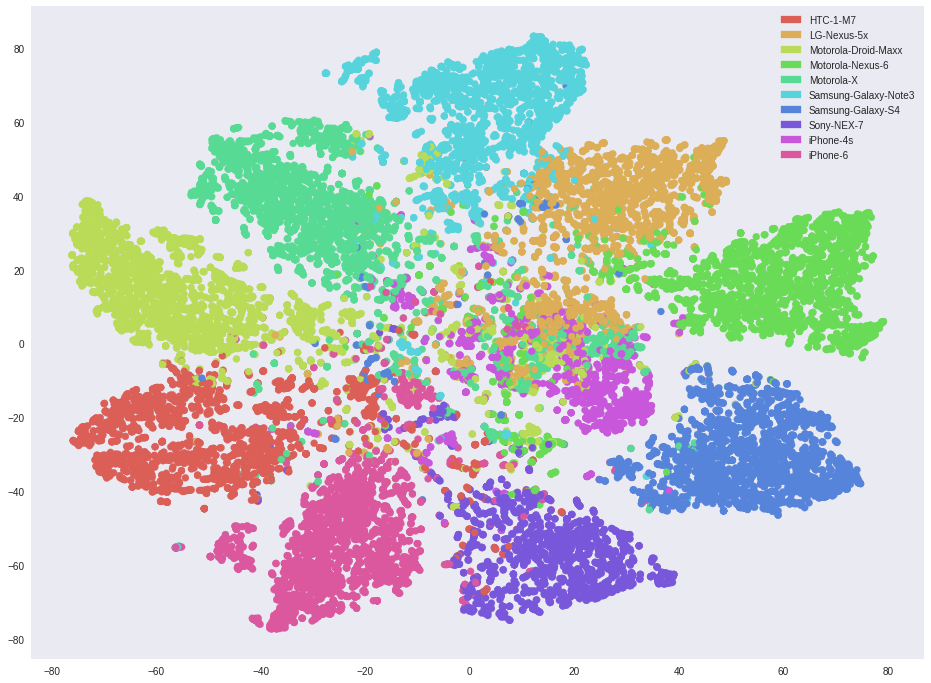

In [30]:
plt.scatter(m_f_pca_tsne[:, 0], m_f_pca_tsne[:, 1], 
            c=[cols[uid2col[i]] for i in range(m_f_pca_tsne.shape[0])])
plt.legend(handles=[mpatches.Patch(color=cols[i], label=idx2class[i]) for i in range(10)])

In [32]:
[k, d[''] for k, d in data.items()]

KeyboardInterrupt: 

In [ ]:
d